In [1]:
from src.kernel.timeline import Timeline
from src.components.optical_channel import ClassicalChannel, QuantumChannel
from src.kernel.event import Event
from src.kernel.process import Process
from src.topology.node import raman_receiver_node, raman_sender_node
from src.entanglement_management.raman_protocols import RamanTestReceiver
from matplotlib import pyplot as plt
import traceback
import numpy as np

In [2]:
def init_experiment_setup(params):
    sender = raman_sender_node("sender", params["tl"], params["num_iterations"], params["clock_power"], params["narrow_band_filter_bandwidth"], params["quantum_channel_wavelength"], 
                               params["mean_photon_num"], params["is_distinguishable"], params["pulse_separation"], params["batch_size"], params["pulse_width"])
    signal_receiver = raman_receiver_node("signal_receiver", params["tl"], 'sender', params["collection_probability"], params["dark_count_rate"], params["dead_time"], params["time_resolution"])
    idler_receiver = raman_receiver_node("idler_receiver", params["tl"], 'sender', params["collection_probability"], params["dark_count_rate"], params["dead_time"], params["time_resolution"])

    receiver_protocol = RamanTestReceiver(signal_receiver, idler_receiver, 'sender', params["pulse_separation"])

    signal_receiver.attach_detector_to_receiver(receiver_protocol)
    idler_receiver.attach_detector_to_receiver(receiver_protocol)
    sender.attach_lightsource_to_receivers("signal_receiver", "idler_receiver")


    signal_channel = QuantumChannel("signal_channel", params["tl"], params["quantum_channel_attenuation"], params["classical_channel_attenuation"], params["distance"], params["raman_coefficient"], 
                                    params["polarization_fidelity"], params["light_speed"], params["max_rate"], params["quantum_channel_wavelength"], params["classical_channel_wavelength"])
    idler_channel = QuantumChannel("idler_channel", params["tl"], params["quantum_channel_attenuation"], params["classical_channel_attenuation"], params["distance"], params["raman_coefficient"], 
                                    params["polarization_fidelity"], params["light_speed"], params["max_rate"], params["quantum_channel_wavelength"], params["classical_channel_wavelength"])
    classical_channel = ClassicalChannel("classical_channel", params["tl"], params["distance"])
    signal_channel.set_ends(sender, "signal_receiver")
    idler_channel.set_ends(sender, "idler_receiver")
    classical_channel.set_ends(sender, "signal_receiver")

    return sender

In [3]:
experimental_parameters = {
    "tl" : Timeline(5000e12),

    # Parameters
    # Detector_parameters
    "collection_probability" : 0.8,
    "dark_count_rate" : 100,
    "dead_time" : 250,
    "time_resolution" : 50,

    # Optical channel
    "quantum_channel_attenuation" : 0.44,
    "classical_channel_attenuation" : 0.5,
    "distance" : 2,
    "raman_coefficient" : 33e-10,
    "polarization_fidelity" : 1,
    "light_speed" : 3e8,
    "max_rate" : 1e12,
    "quantum_channel_wavelength" : 1536e-9,
    "classical_channel_wavelength" : 1610e-9,

    # Light Source
    # "wavelength" : quantum_channel_wavelength,
    "mean_photon_num" : 0.01, # 0.01
    "is_distinguishable" : True,
    "pulse_separation" : 5e3,
    "pulse_width" : 80,
    "batch_size" : 50000000,
    "num_iterations" : 1,

    # Clock parameters
    "clock_power" : 0.0003,
    "narrow_band_filter_bandwidth" : 0.03,
}

In [4]:
try:
    for i in np.logspace(-5, -1, 30):
        experimental_parameters["tl"] = Timeline(5000e12)
        experimental_parameters["mean_photon_num"] = i
        sender = init_experiment_setup(experimental_parameters)
        process = Process(sender.protocol, "start", [])
        event = Event(0, process)
        experimental_parameters["tl"].schedule(event)

        experimental_parameters["tl"].init()
        experimental_parameters["tl"].run()

    # print(signal_receiver.protocol.coincidence_times)
    
    # n, bins, patches = plt.hist(signal_receiver.protocol.detection_times, range(-28125, 28126, 6250))
    # plt.show()    
except Exception:
    print(traceback.format_exc())

last emit time: 254000000000.0
Raman photosns added 45567
pulse window ID 0
stopped sim and starting processing
sorting window 0
done with dark count removal
done with dark count removal
sorted window 0
found correlations for window: 0
CAR: 450.0
last emit time: 254000000000.0
Raman photosns added 45567
pulse window ID 0
stopped sim and starting processing
sorting window 0
done with dark count removal
done with dark count removal
sorted window 0
found correlations for window: 0
CAR: 396.0
last emit time: 254000000000.0
Raman photosns added 45567
pulse window ID 0
stopped sim and starting processing
sorting window 0
done with dark count removal
done with dark count removal
sorted window 0
found correlations for window: 0
CAR: 449.0
last emit time: 254000000000.0
Raman photosns added 45567
pulse window ID 0
stopped sim and starting processing
sorting window 0
done with dark count removal
done with dark count removal
sorted window 0
found correlations for window: 0
CAR: 1114.0
last emit t

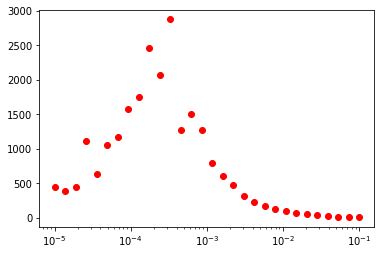

In [5]:
file = open("CAR_Data.txt")
CAR_Data = file.readlines()
plt.plot(np.logspace(-5, -1, 30), list(map(float, CAR_Data)), "ro")
plt.xscale("log")